# Keras Model fit using generator 

How to use generator with model.fit. 

## Issue

Cannot use ```sprse_categorical_crossentropy``` and sparse index labels when using generator as the training data.

* [keras.Model.fit does not work correctly with generator and sparse categorical crossentropy loss](https://stackoverflow.com/questions/77534387)

In [1]:
import os
import sys
import pathlib
import shutil
from typing import (
    Optional,
    Tuple,
    Generator,
    Any
)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import (
    __version__
)


from keras.layers import (
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dense,
    Flatten,
    Dropout,
)
from keras.models import (
    Model,
)
from keras.optimizers import (
    Adam
)
from sklearn.model_selection import train_test_split

print("TensorFlow version: {}".format(tf.__version__))
tf.keras.__version__ = __version__
print("Keras version: {}".format(tf.keras.__version__))

2023-11-23 15:09:46.300693: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 15:09:46.327400: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 15:09:46.327435: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 15:09:46.327469: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-23 15:09:46.336095: I tensorflow/core/platform/cpu_feature_g

TensorFlow version: 2.14.1
Keras version: 2.14.0


# GPU

In [3]:
MEMORY_LIMIT = 5 * 1024

print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
      
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY_LIMIT)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs
Virtual devices cannot be modified after being initialized


2023-11-23 15:09:47.638066: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 15:09:47.647372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 15:09:47.647629: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Constant

In [4]:
NUM_CLASSES = 10
INPUT_SHAPE = (32, 32, 3)
USE_SPARCE_LABEL = False

# CIFAR-10

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)
x_train.shape

(40000, 32, 32, 3)

In [6]:
# One Hot Encoding the labels
if not USE_SPARCE_LABEL:
    y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
    y_validation = keras.utils.to_categorical(y_validation, NUM_CLASSES)
    y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Model

In [7]:
inputs = tf.keras.Input(
    name='image',
    shape=INPUT_SHAPE,
    dtype=tf.float32
) 

x = Conv2D(                                           
    filters=32, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu', 
    input_shape=INPUT_SHAPE
)(inputs)
x = BatchNormalization()(x)
x = Conv2D(                                           
    filters=64, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu'
)(x)
x = MaxPooling2D(                                     
    pool_size=(2, 2)
)(x)
x = Dropout(0.20)(x)

x = Conv2D(                                           
    filters=128, 
    kernel_size=(3, 3), 
    strides=(1, 1), 
    padding="same",
    activation='relu'
)(x)
x = BatchNormalization()(x)
x = MaxPooling2D(                                     
    pool_size=(2, 2)
)(x)
x = Dropout(0.20)(x)

x = Flatten()(x)
x = Dense(300, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.20)(x)
x = Dense(200, activation="relu")(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model: Model = Model(
    inputs=inputs, outputs=outputs, name="cifar10"
)

# --------------------------------------------------------------------------------
# Compile model
# --------------------------------------------------------------------------------
learning_rate = 1e-3

if USE_SPARCE_LABEL:
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
else:
    loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(
    optimizer=Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss=loss_fn,
    metrics=["accuracy"]
)
model.summary()

Model: "cifar10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0   

---
# Training


In [8]:
batch_size = 16
number_of_epochs = 10

## Augmented (images, labels) generator

images and labels are batched with ```batch_size```.

In [9]:
def data_label_generator(x, y):
    def _f():
        index = 0
        length = len(x)
        try: 
            while True:                
                yield x[index:index+batch_size], y[index:index+batch_size]
                index = (index + batch_size) % length
        except StopIteration:
            return
        
    return _f

In [10]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy'
)

In [11]:
steps_per_epoch = len(y_train) // batch_size
validation_steps = (len(y_validation) // batch_size) - 1

history = model.fit(
    x=data_label_generator(x_train, y_train)(),
    batch_size=batch_size,
    epochs=number_of_epochs,
    verbose=1,
    validation_data=data_label_generator(x_validation, y_validation)(),
    shuffle=True,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_batch_size=batch_size,
    callbacks=[
        earlystop_callback
    ]
)

Epoch 1/10


2023-11-23 15:09:49.290036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape incifar10/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-23 15:09:49.423526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-23 15:09:50.326331: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc060243090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-23 15:09:50.326347: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2023-11-23 15:09:50.329362: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-23 15:09:50.392493: I ./tensorflow/compiler/jit/device_compiler.h:1

2500/2500 [==============================] - 24s 8ms/step - loss: 1.4146 - accuracy: 0.4997 - val_loss: 1.0906 - val_accuracy: 0.6105
Epoch 2/10
2500/2500 [==============================] - 21s 9ms/step - loss: 1.0306 - accuracy: 0.6375 - val_loss: 0.9779 - val_accuracy: 0.6532
Epoch 3/10
2500/2500 [==============================] - 22s 9ms/step - loss: 0.8780 - accuracy: 0.6925 - val_loss: 0.8194 - val_accuracy: 0.7127
Epoch 4/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.7641 - accuracy: 0.7315 - val_loss: 0.9330 - val_accuracy: 0.7014
Epoch 5/10
2500/2500 [==============================] - 21s 8ms/step - loss: 0.6797 - accuracy: 0.7614 - val_loss: 0.7908 - val_accuracy: 0.7311
Epoch 6/10
2500/2500 [==============================] - 21s 9ms/step - loss: 0.6182 - accuracy: 0.7841 - val_loss: 0.7371 - val_accuracy: 0.7533
Epoch 7/10
2500/2500 [==============================] - 21s 9ms/step - loss: 0.4981 - accuracy: 0.8217 - val_loss: 0.8221 - val_accuracy: 0.7

---
# Evaluation

In [12]:
results = model.evaluate(x_test, y_test, batch_size=100)
print("test loss, test accuracy:", results)

100/100 [==============================] - 1s 6ms/step - loss: 0.8661 - accuracy: 0.7434
test loss, test accuracy: [0.8661438226699829, 0.743399977684021]


1/1 [==============================] - 0s 14ms/step
automobile


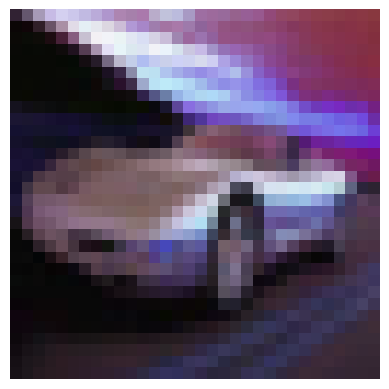

In [19]:
index = np.random.choice(range(len(x_test)))
predictions = np.argmax(model.predict(x_test[index].reshape((1, 32, 32, 3))), axis=-1)
predictions

LIB_DIR = "/home/eml/home/repository/git/oonisim/lib/code/python"
if LIB_DIR not in sys.path:
    sys.path.append(
        LIB_DIR    
    )
class_labels = np.array([
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
])
from lib.util_opencv.image import (
    show_image,
)
image = x_test[index] * 255.0
show_image(image.astype(np.uint8))
print(class_labels[predictions[0]])